In [139]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from keras.layers import Lambda

In [160]:
fine = np.load("ERA_wind.npz")

u = fine.get('wind_u')
v = fine.get('wind_v')

# wind_speeds = [[[np.sqrt((u[i][1][lat][lon])**2 + (v[i][1][lat][lon])**2) for lon in range(201)] for lat in range(121)] for i in range(744)]

wind_v = fine["wind_v"][:744, 0, :120, :200]
wind_u = fine["wind_u"][:744, 0, :120, :200]
wind_scalar = [np.sqrt(arr1**2 + arr2**2) for arr1, arr2 in zip(wind_v, wind_u)] # create array with wind scalar vales


len(wind_speeds), len(wind_speeds[0]), len(wind_speeds[0][0])


(744, 121, 201)

In [161]:
## Train Data

train_files = os.listdir("proj-turbulence/train")

coarse_train = []
fine_train = []
for file in train_files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_train.append(np.load(str("proj-turbulence/train/" + file))) # load file, save into coarse
        fine_train.append(wind_scalar[int(timestamp)]) # load fine version


In [162]:
## Test Data

test_files = os.listdir("proj-turbulence/test")

test_files

coarse_test = []
fine_test = []
for file in test_files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_test.append(np.load(str("proj-turbulence/test/" + file))) # load file, save into coarse
        fine_test.append(wind_scalar[int(timestamp)]) # load fine version

In [163]:
## Val Data

val_files = os.listdir("proj-turbulence/val")

coarse_val = []
fine_val = []
for file in val_files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_val.append(np.load(str("proj-turbulence/val/" + file))) # load file, save into coarse
        fine_val.append(wind_scalar[int(timestamp)]) # load fine version

In [164]:
## CNN

import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from torch import tensor, argmax

class PairedImageDataset(Dataset):
    def __init__(self, coarse_images, high_res_images, transform=None):
        self.coarse_images = coarse_images
        self.high_res_images = high_res_images
        self.transform = transform

    def __len__(self):
        return len(self.coarse_images)

    def __getitem__(self, idx):
        coarse_img = self.coarse_images[idx]
        high_res_img = self.high_res_images[idx]

        if self.transform:
            coarse_img = self.transform(coarse_img)
            high_res_img = self.transform(high_res_img)

        return coarse_img, high_res_img

transform = transforms.Compose([
    transforms.ToPILImage(),
#   transforms.Resize((121,201)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train = PairedImageDataset(tensor(np.array(coarse_train)), tensor(np.array(fine_train)), transform=transform)
test = PairedImageDataset(tensor(np.array(coarse_test)), tensor(np.array(fine_test)), transform=transform)
val = PairedImageDataset(tensor(np.array(coarse_val)), tensor(np.array(fine_val)), transform=transform)

# load
batch_size = 16
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

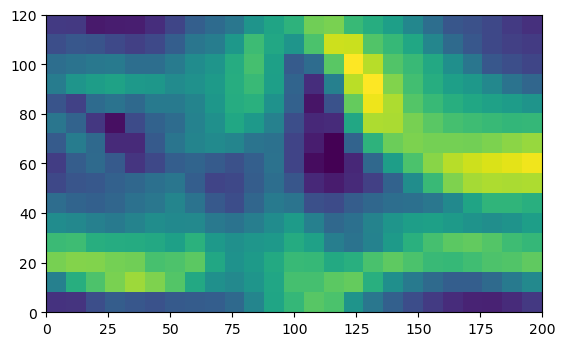

In [137]:
plt.imshow(coarse_train[0], origin='lower', cmap='viridis', extent=[0, 200, 0, 120])


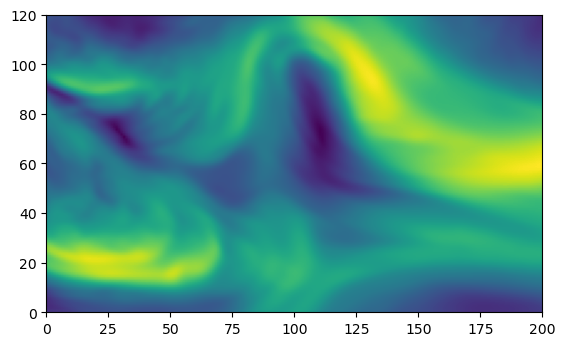

In [138]:
plt.imshow(fine_train[0], origin='lower', cmap='viridis', extent=[0, 200, 0, 120])


In [158]:
class CNN(nn.Module):
    def __init__(self):
        upscale = 8
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(16, upscale**2, kernel_size=3, padding= 1),
            nn.ReLU()
        )
        self.depth_to_space = nn.PixelShuffle(upscale)
        
    def forward(self, x):
        x = self.conv_layers(x.float())
        x = self.depth_to_space(x)
        return x
    
model = CNN()

In [159]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [165]:
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=0.00001)
loss_values = []
val_loss_values = []
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets.squeeze())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')
    loss_values.append(loss.item())
    val_loss_values.append(val_loss.item())

Epoch 1/100, Loss: 0.31998205184936523, Val Loss: 0.3187486529350281
Epoch 2/100, Loss: 0.31731507182121277, Val Loss: 0.3177643418312073
Epoch 3/100, Loss: 0.3147639036178589, Val Loss: 0.3171441853046417
Epoch 4/100, Loss: 0.31488898396492004, Val Loss: 0.31553399562835693
Epoch 5/100, Loss: 0.31361040472984314, Val Loss: 0.31341078877449036
Epoch 6/100, Loss: 0.31347715854644775, Val Loss: 0.3112616240978241
Epoch 7/100, Loss: 0.30771341919898987, Val Loss: 0.3085397183895111
Epoch 8/100, Loss: 0.3027885854244232, Val Loss: 0.3042450547218323
Epoch 9/100, Loss: 0.2992970943450928, Val Loss: 0.29766660928726196
Epoch 10/100, Loss: 0.28974178433418274, Val Loss: 0.288593590259552
Epoch 11/100, Loss: 0.27973616123199463, Val Loss: 0.27754175662994385
Epoch 12/100, Loss: 0.26584118604660034, Val Loss: 0.26338574290275574
Epoch 13/100, Loss: 0.24772119522094727, Val Loss: 0.249238982796669
Epoch 14/100, Loss: 0.22622673213481903, Val Loss: 0.22615580260753632
Epoch 15/100, Loss: 0.200195

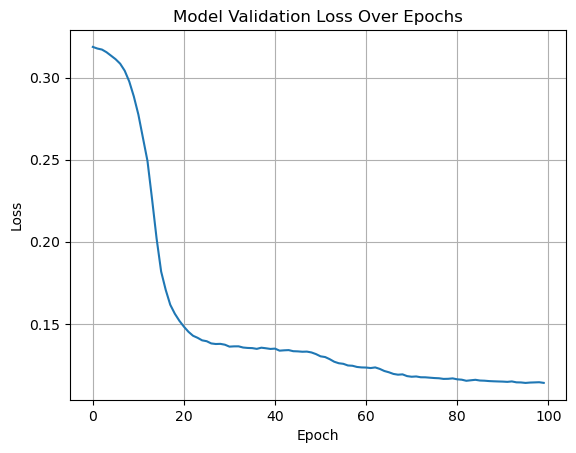

In [166]:
plt.plot(val_loss_values, linestyle='-')
plt.title('Model Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

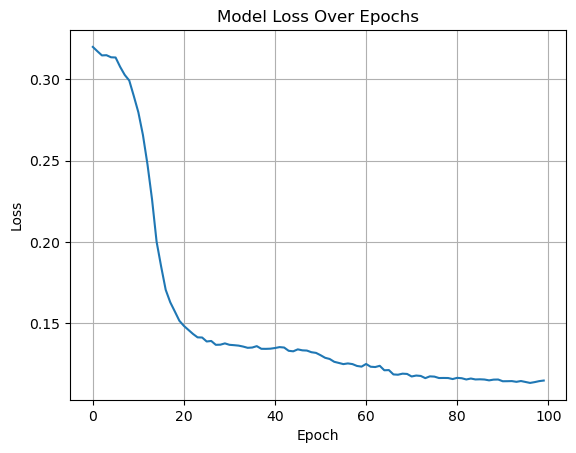

In [167]:
plt.plot(loss_values, linestyle='-')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()